## Import data, set logging level

In [1]:
from mne.datasets import multimodal
import mne
mne.set_log_level(verbose='CRITICAL')
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from deepmeg.training.callbacks import Callback, EarlyStopping, L2Reg
from deepmeg.training.trainers import Trainer
from deepmeg.data.datasets import read_epochs_dataset, EpochsDataset
from deepmeg.preprocessing.transforms import zscore
import torch
import torch.nn as nn
from collections import defaultdict
from deepmeg.data.utils import make_train_and_val_loaders
from torch.utils.data import DataLoader, Dataset
from deepmeg.models.interpretable import LFCNN
from deepmeg.interpreters import LFCNNInterpreter
import torchmetrics
from deepmeg.training.callbacks import PrintingCallback
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import matplotlib
import scipy as sp

/data/pt_02648/deepmeg/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = read_epochs_dataset('../data/multimodal.pt')

In [3]:
from mne.datasets import multimodal
fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')

info = mne.io.read_raw_fif(fname_raw).pick_types(meg='grad').info

In [4]:
train, test = torch.utils.data.random_split(dataset, [.7, .3])

In [5]:
# very simple function to plot history of the model training

def plot_metrics(metrics: dict[str, np.ndarray]):
    plot_dict = defaultdict(dict)

    for metric, values in metrics.items():
        metric_data = metric.split('_')
        metric_name = '_'.join(metric_data[:-1])
        metric_kind = metric_data[-1]
        plot_dict[metric_name][metric_kind] = values

    for metric_name, kind_dict in plot_dict.items():
        legend = list()
        for metric_kind, kind in kind_dict.items():
            plt.plot(kind)
            legend.append(metric_kind)
        plt.title(metric_name)
        plt.legend(legend)
        plt.show()

In [6]:
model = LFCNN(
    n_channels=204, # ~ number of channels (gradiometers)
    n_latent=8, # ~ number of latent factors
    n_times=301, # ~ number of samples in epoch after preprocessing
    filter_size=50, # ~ FIR filter size
    pool_factor=10, # ~ take each 10th sample from spatially filtered components
    n_outputs=8 # ~ number of output classes (number of events in epochs)
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        # TempConvAveClipping(),
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight', 'temp_conv.weight',
            ], lambdas=.01
        ), # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

In [7]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

  0%|          | 0/150 [00:55<?, ?it/s]


KeyboardInterrupt: 

## Evaluate the model

In [ ]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.1314584958282384
train_binary_accuracy: 0.9756992892785505
loss: 0.22341214729980988
binary_accuracy: 0.9330357096411965


## Model interpretation

In [ ]:
interpreter = LFCNNInterpreter(model, test, info)

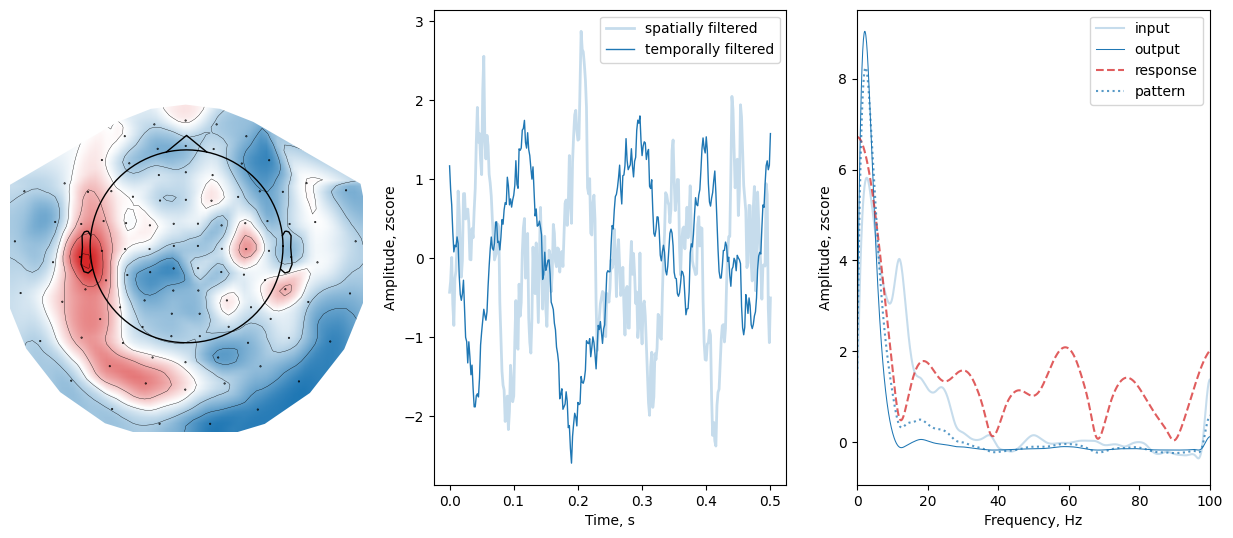

In [ ]:
fig = interpreter.plot_branch(0, ['input', 'output', 'response', 'pattern'])

In [20]:
weights = model.temp_conv.weight.detach()
weights[:, 0, :].mean(-1)

tensor([ 0.0892,  0.0284,  0.0100, -0.0420,  0.0797, -0.0733, -0.0626,  0.0849])

In [132]:
from deepmeg.training.callbacks import Callback

class WeightClipper(object):
    def __init__(self, model):
        self.model = model

    def __call__(self, module):
        # self.model.temp_conv.weight -= self.model.temp_conv.weight.mean(-1, keepdim=True)
        self.model.temp_conv.weight /= (1e-7 + torch.norm(self.model.temp_conv.weight, dim=-1, keepdim=True, p=1))
        # (w/(1e-7 + torch.norm(w, dim=-1, keepdim=True, p=1)))

class TempConvAveClipping(Callback):
    def __init__(self):
        super().__init__()

    def set_trainer(self, trainer: 'Trainer'):
        super().set_trainer(trainer)
        self.model = self.trainer.model
        self.clipper = WeightClipper(self.model)

    @torch.no_grad()
    def on_batch_end(
        self,
        Y: torch.Tensor,
        Y_pred: torch.Tensor,
        metrics: dict
    ):
        self.model.apply(self.clipper)
        # self.model.temp_conv.weight = self.model.temp_conv.weight - self.model.temp_conv.weight.mean(-1, keepdim=True)

In [133]:
model2 = LFCNN(
    n_channels=204, # ~ number of channels (gradiometers)
    n_latent=8, # ~ number of latent factors
    n_times=301, # ~ number of samples in epoch after preprocessing
    filter_size=50, # ~ FIR filter size
    pool_factor=10, # ~ take each 10th sample from spatially filtered components
    n_outputs=8 # ~ number of output classes (number of events in epochs)
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

model2.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        TempConvAveClipping(),
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight', 'temp_conv.weight',
            ], lambdas=.01
        ), # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

Epoch 0:  loss_train:  0.7086   |    binary_accuracy_train:  0.6231   |    loss_val:  0.6864   |    binary_accuracy_val:  0.8112
Epoch 1:  loss_train:  0.6767   |    binary_accuracy_train:  0.8368   |    loss_val:  0.6579   |    binary_accuracy_val:  0.8681
Epoch 2:  loss_train:  0.6482   |    binary_accuracy_train:  0.8702   |    loss_val:  0.6271   |    binary_accuracy_val:  0.8722
Epoch 3:  loss_train:  0.6167   |    binary_accuracy_train:  0.8730   |    loss_val:  0.5937   |    binary_accuracy_val:  0.8743
Epoch 4:  loss_train:  0.5816   |    binary_accuracy_train:  0.8734   |    loss_val:  0.5587   |    binary_accuracy_val:  0.8750
Epoch 5:  loss_train:  0.5441   |    binary_accuracy_train:  0.8735   |    loss_val:  0.5244   |    binary_accuracy_val:  0.8716
Epoch 6:  loss_train:  0.5073   |    binary_accuracy_train:  0.8715   |    loss_val:  0.4945   |    binary_accuracy_val:  0.8662
Epoch 7:  loss_train:  0.4761   |    binary_accuracy_train:  0.8709   |    loss_val:  0.4721   | 

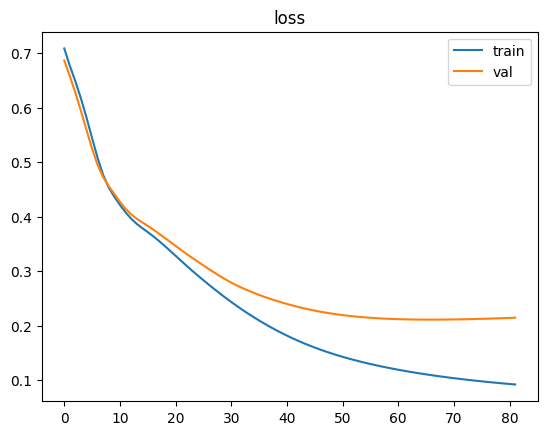

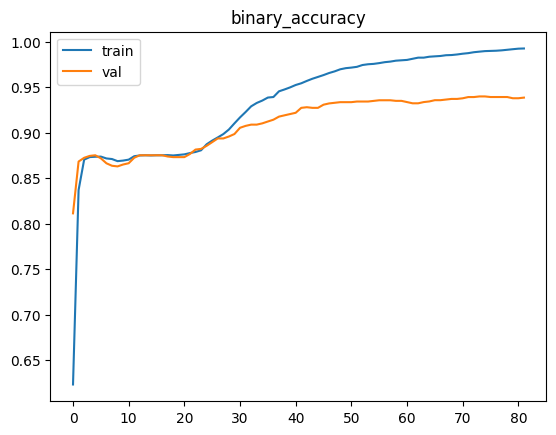

In [134]:
history = model2.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [135]:
train_result = model2.evaluate(train)
result = model2.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.13118820840662176
train_binary_accuracy: 0.9746503504839811
loss: 0.21359931067986923
binary_accuracy: 0.929788968779824


In [136]:
w = model.temp_conv.weight.detach()
w.shape

torch.Size([8, 1, 50])

In [137]:
torch.abs((w/(1e-7 + torch.norm(w, dim=-1, keepdim=True, p=1)))).sum(-1)

tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]])

In [138]:
weights = model2.temp_conv.weight.detach()
torch.abs(weights[:, 0, :]).sum(-1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

In [139]:
torch.abs(weights[:, 0, :]).mean(-1)

tensor([0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200])

In [140]:
weights[:, 0, :].mean(-1)

tensor([ 0.0200,  0.0200,  0.0200, -0.0200,  0.0054,  0.0200,  0.0200,  0.0200])

In [141]:
interpreter2 = LFCNNInterpreter(model2, test, info)

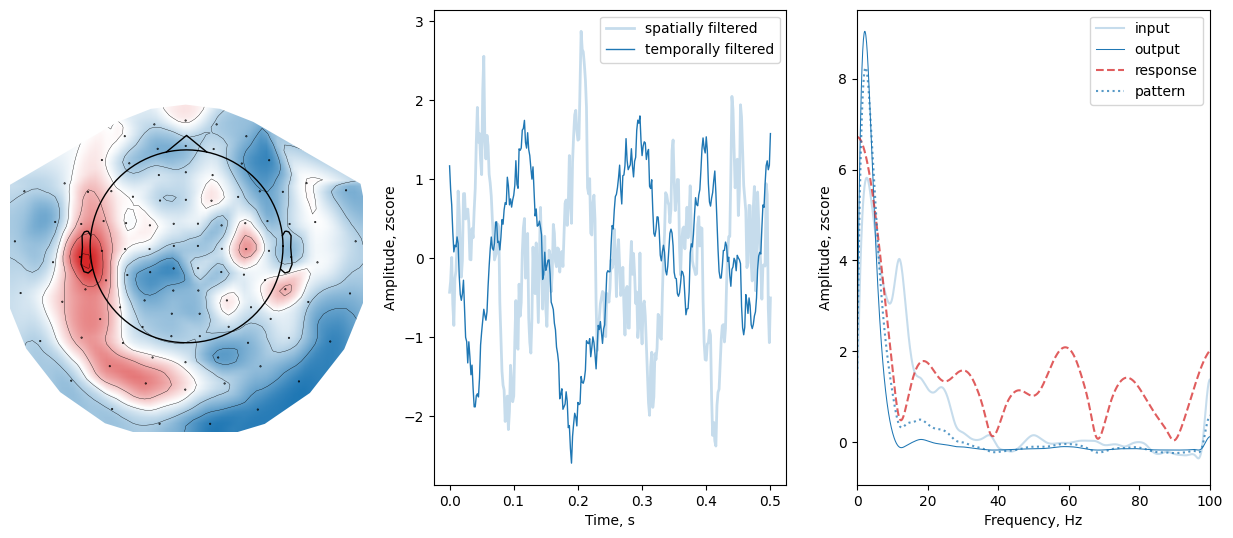

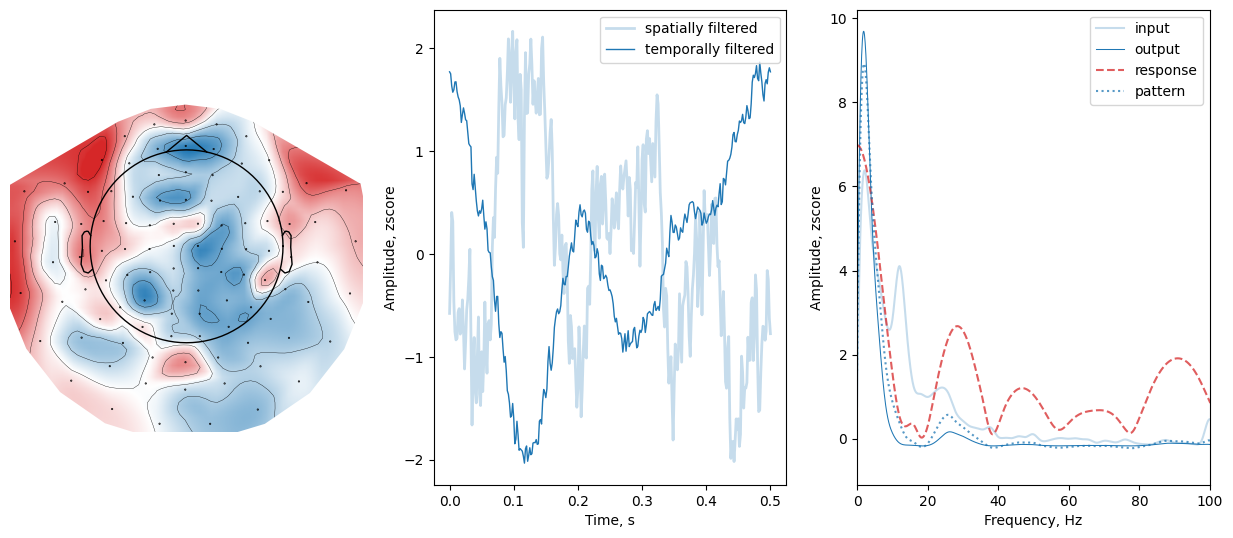

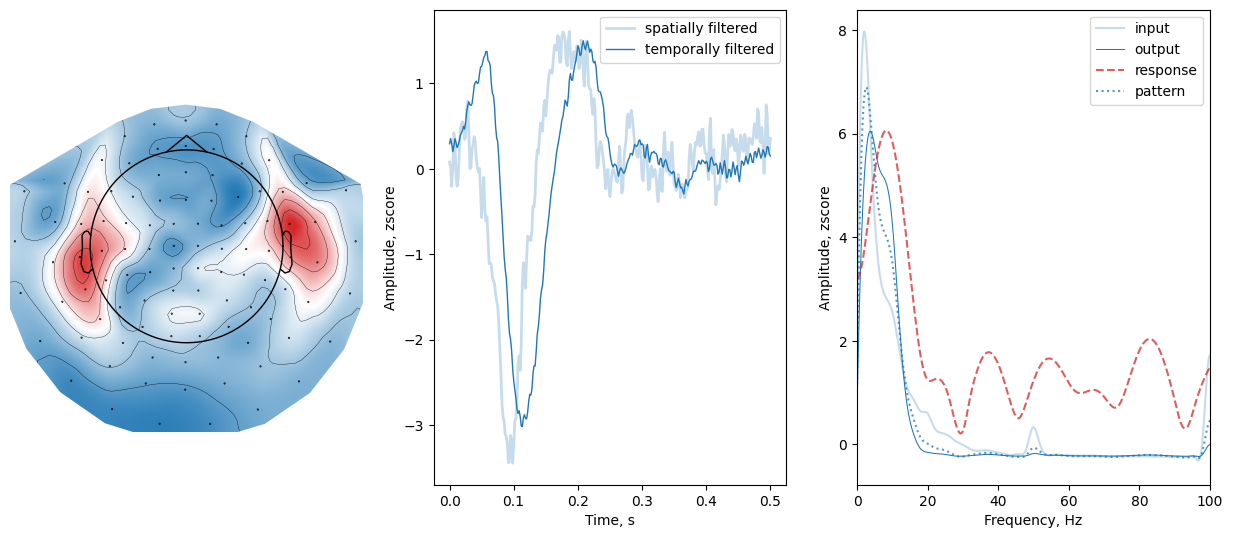

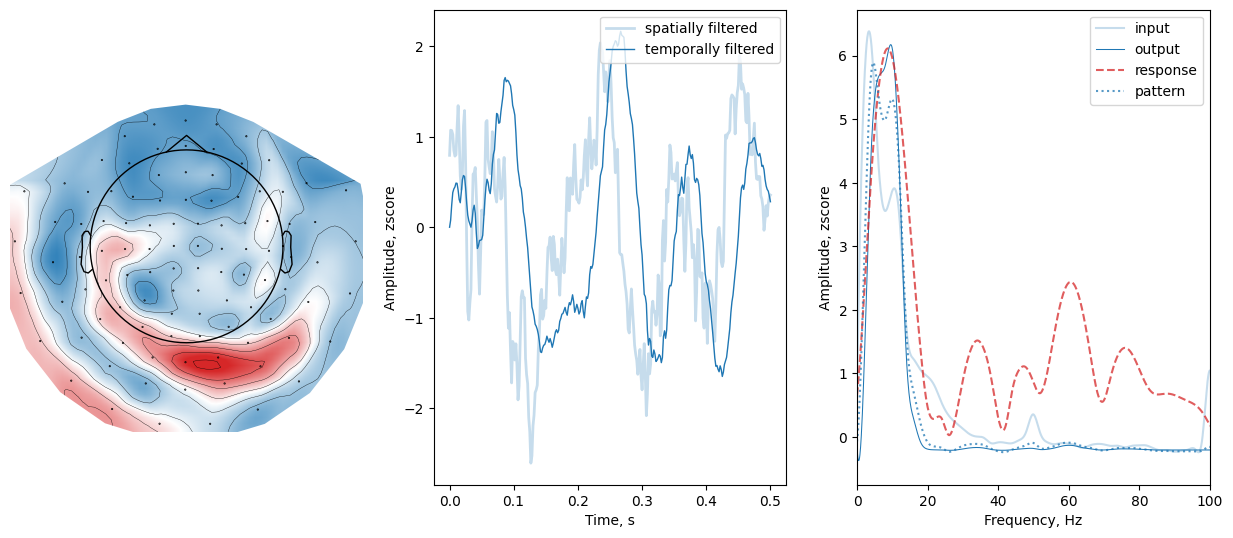

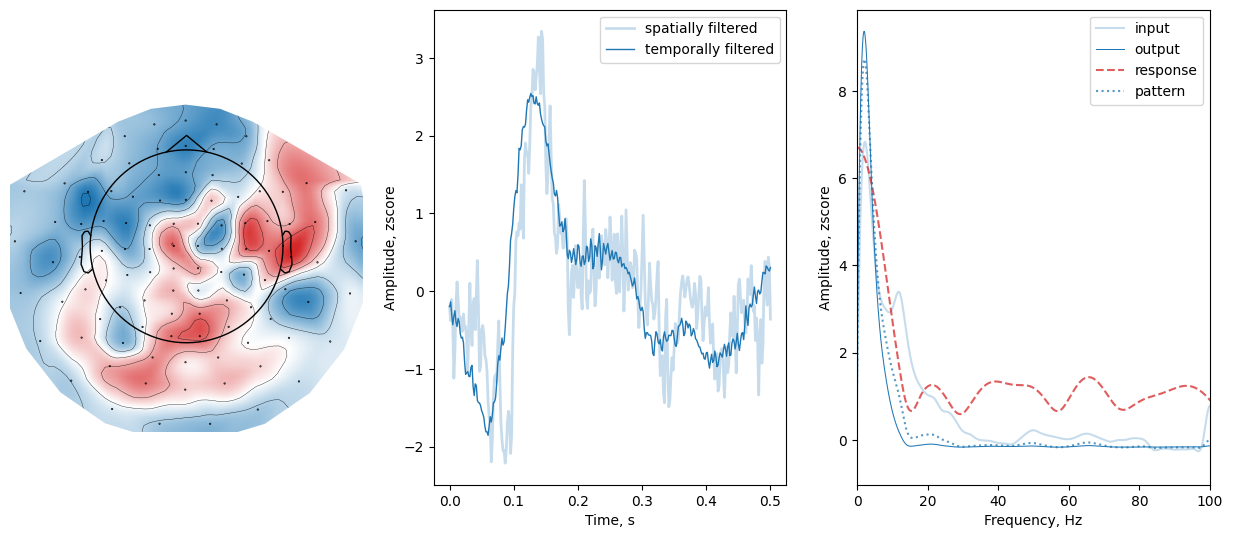

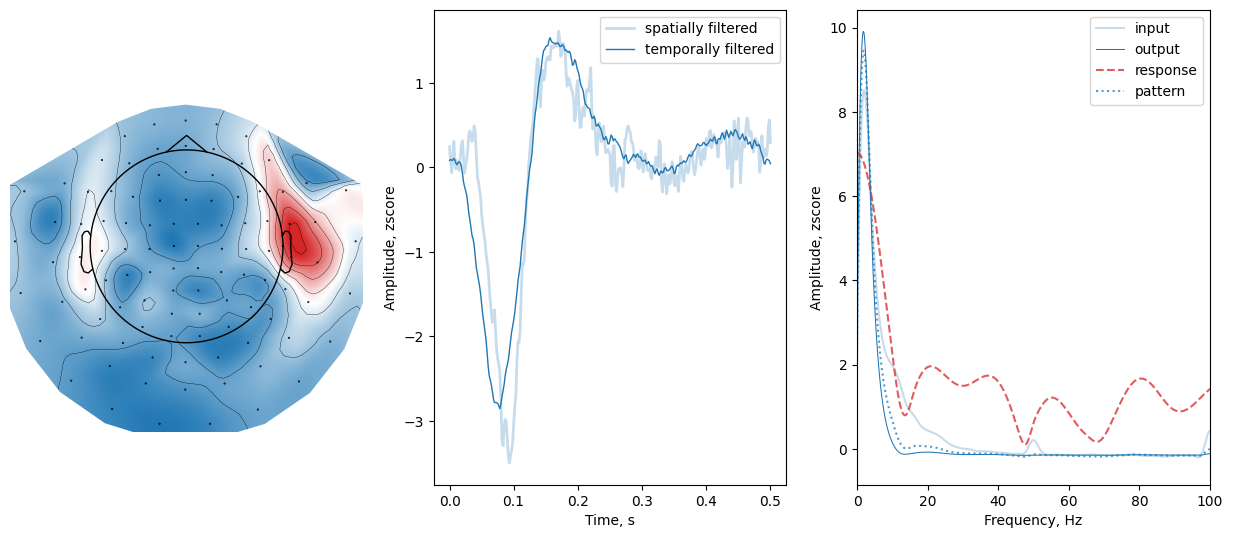

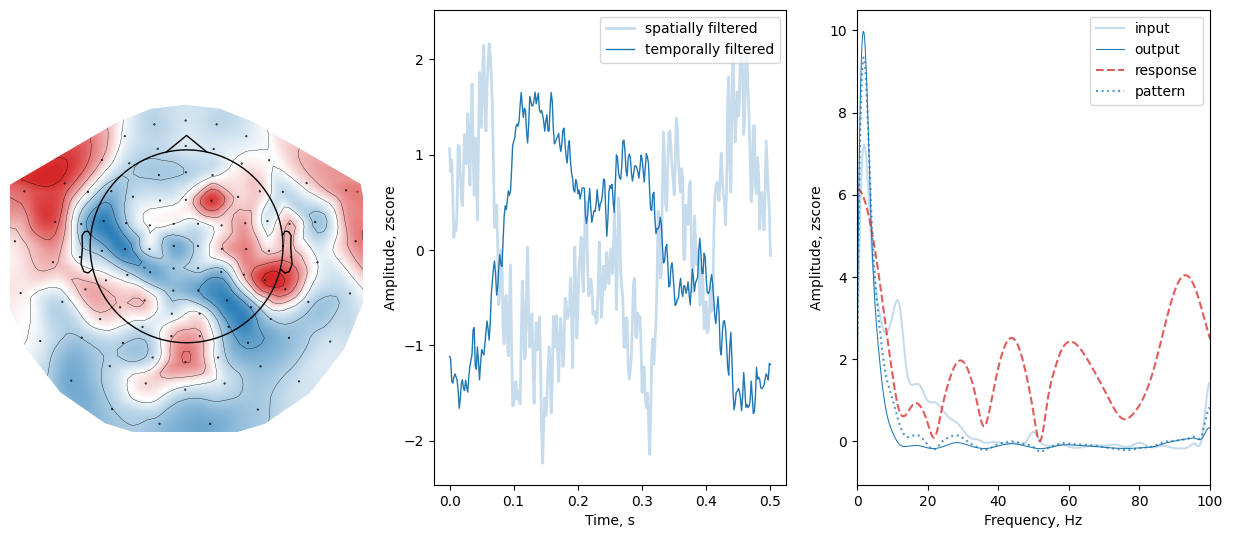

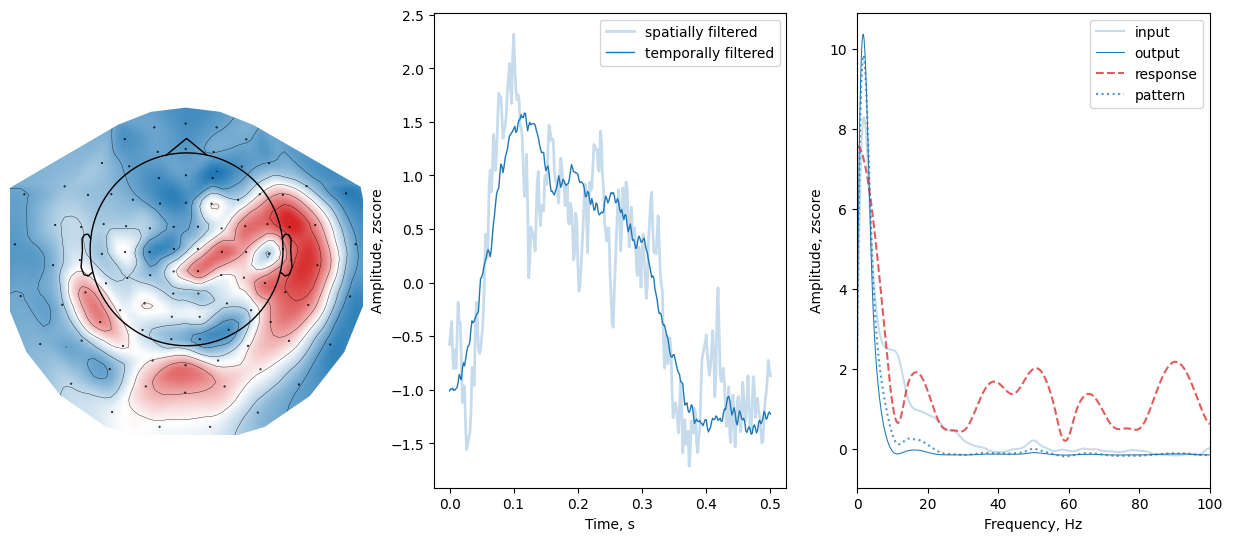

In [105]:
for i in range(8):
    fig = interpreter.plot_branch(i, ['input', 'output', 'response', 'pattern'])
    plt.show()

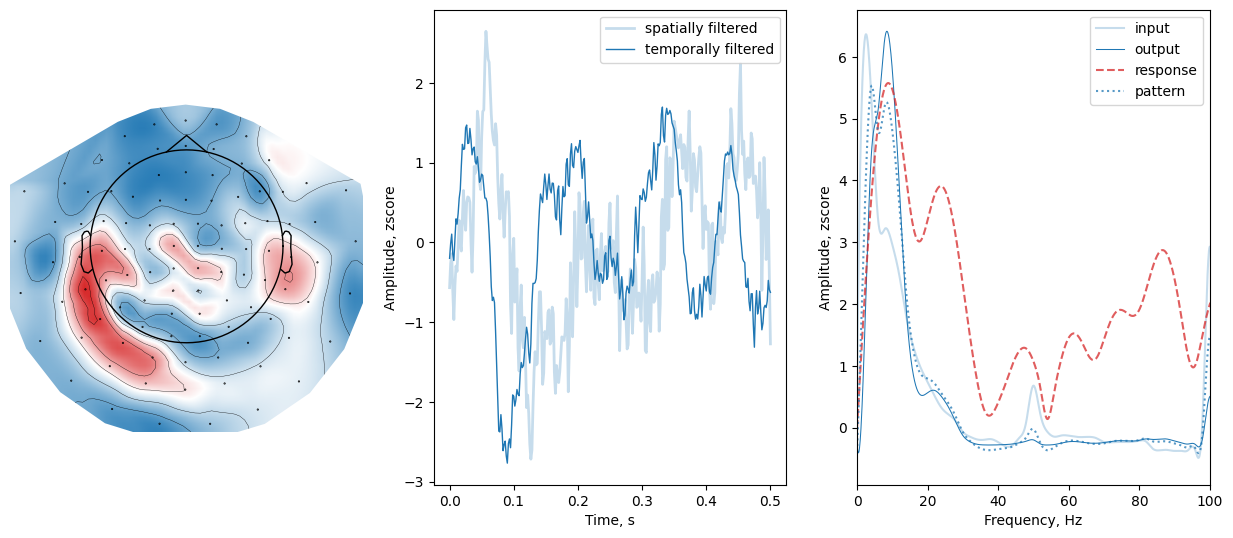

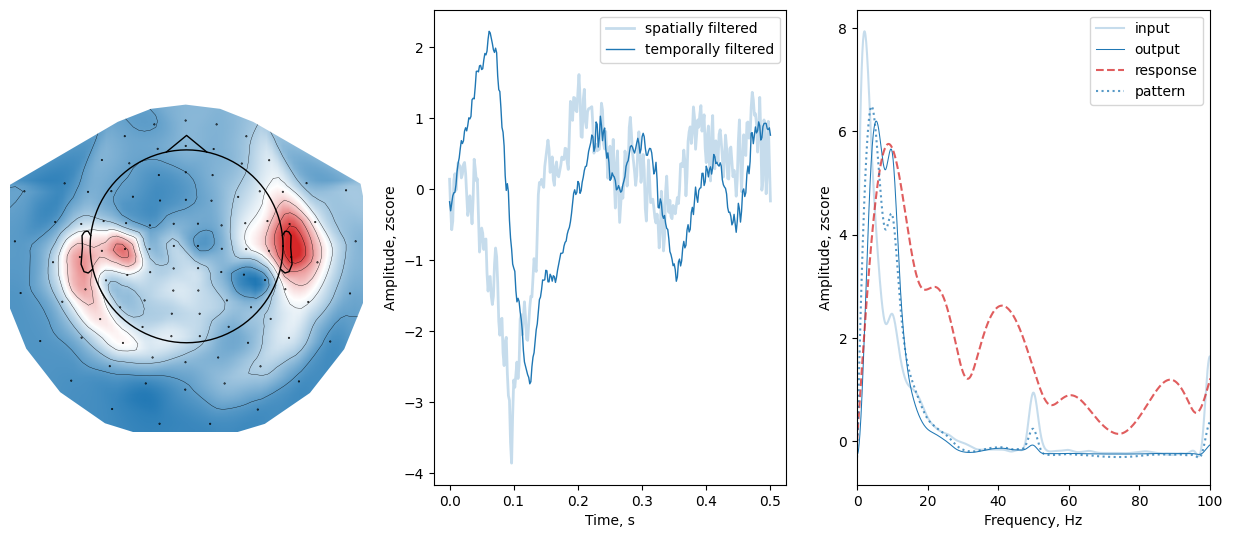

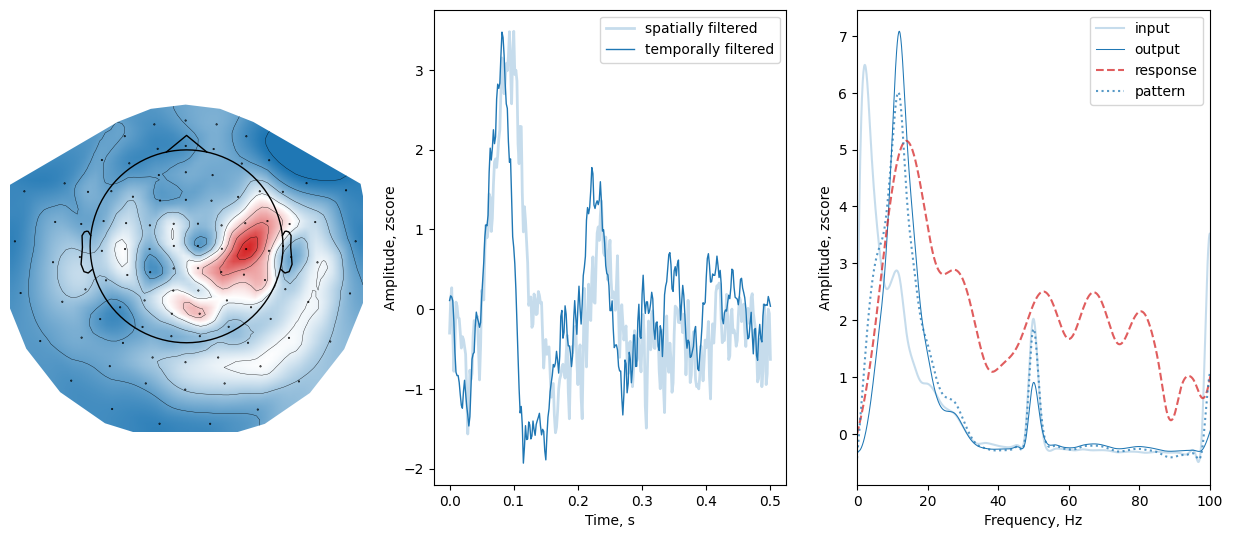

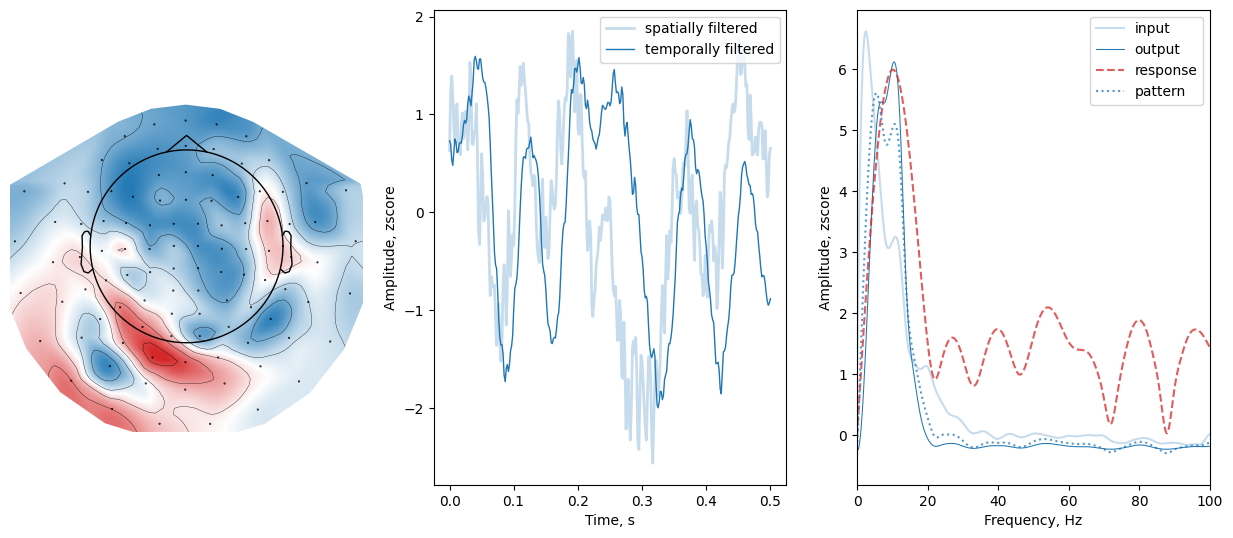

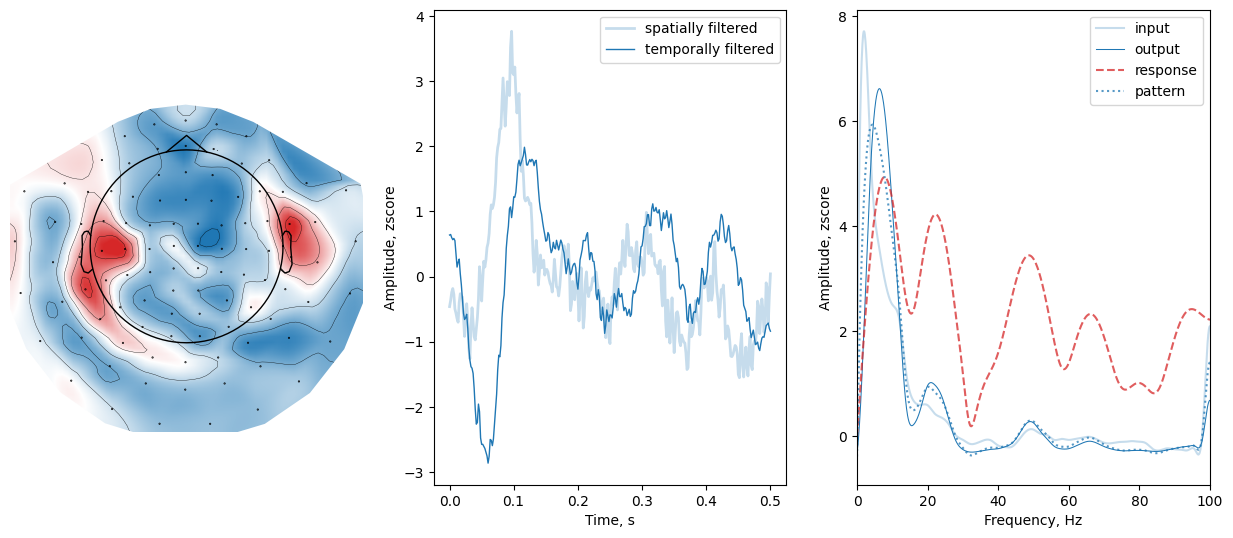

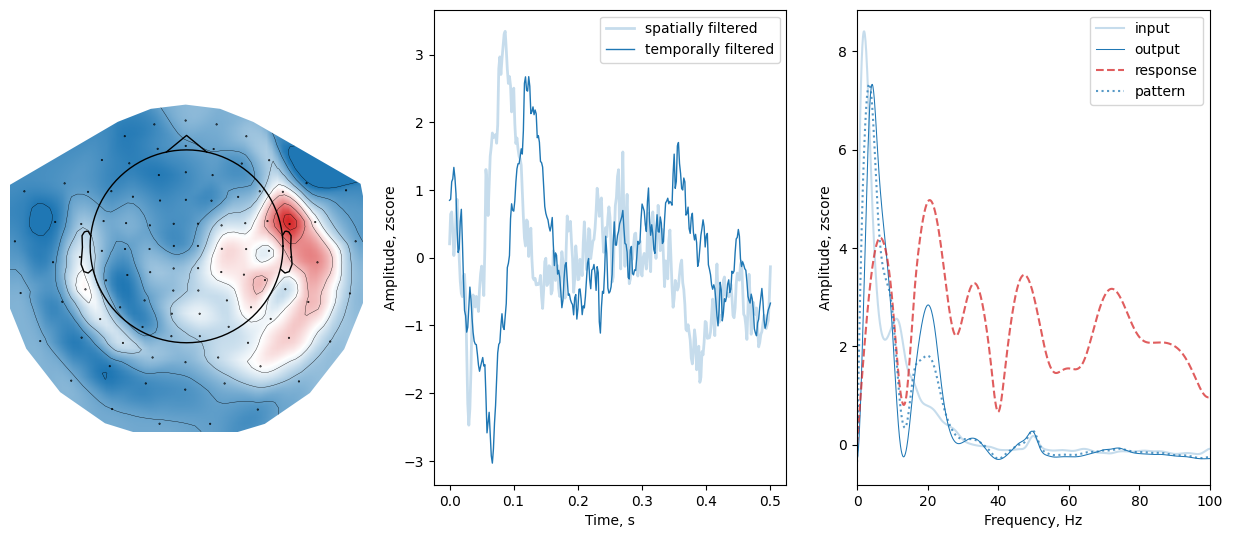

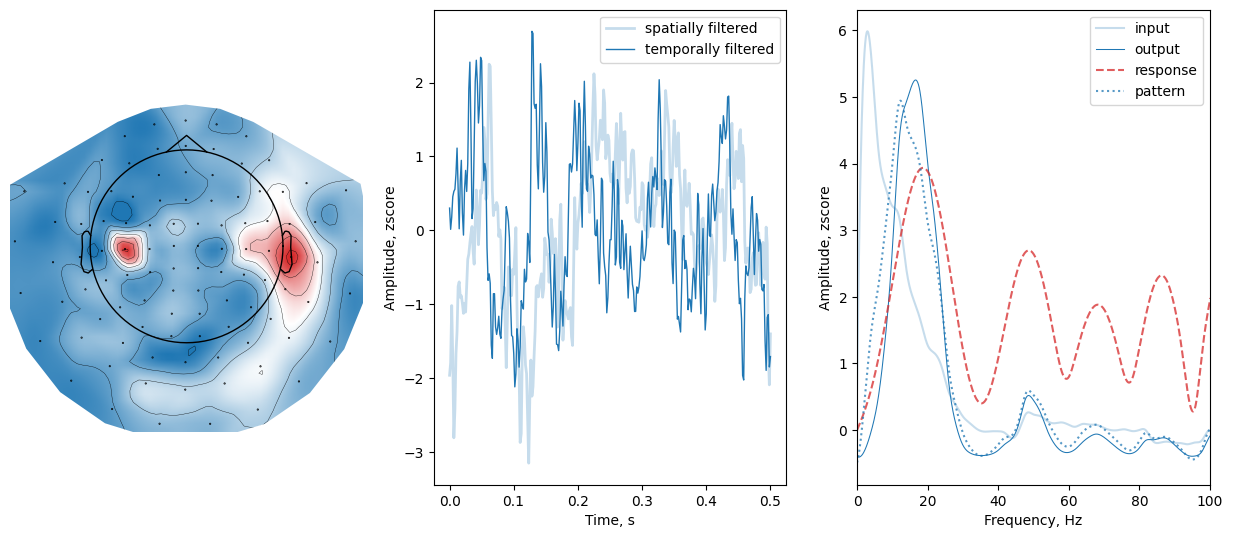

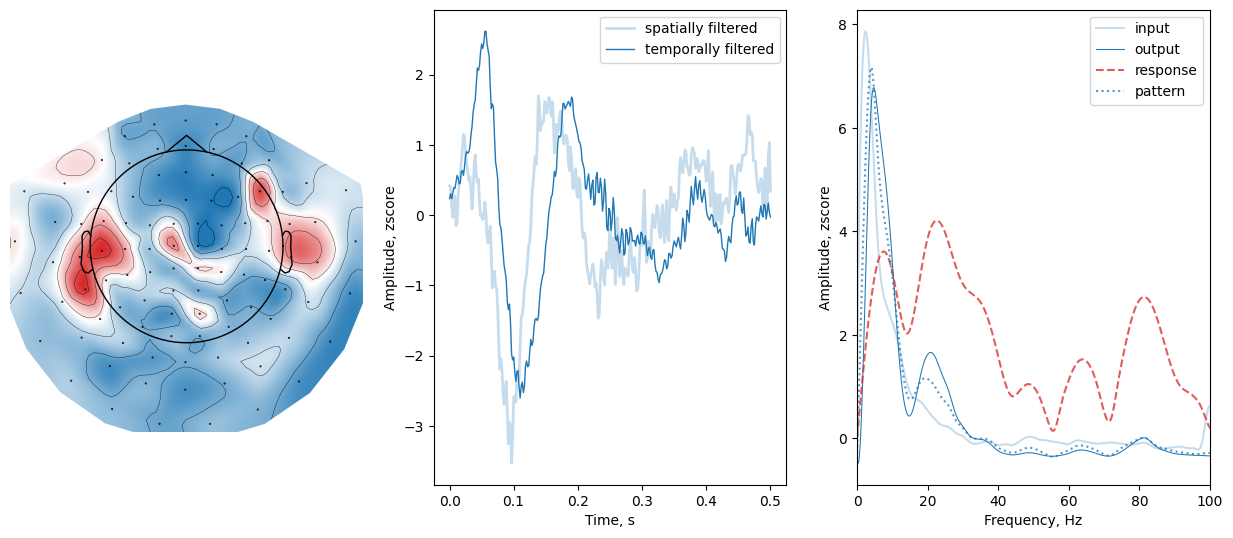

In [131]:
for i in range(8):
    fig = interpreter2.plot_branch(i, ['input', 'output', 'response', 'pattern'])
    plt.show()

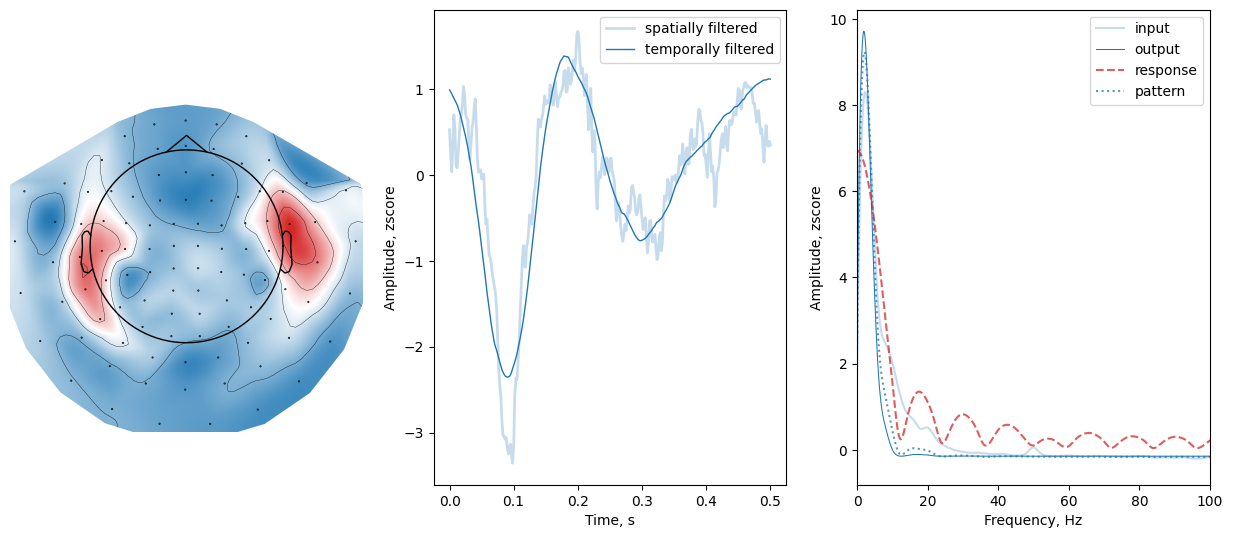

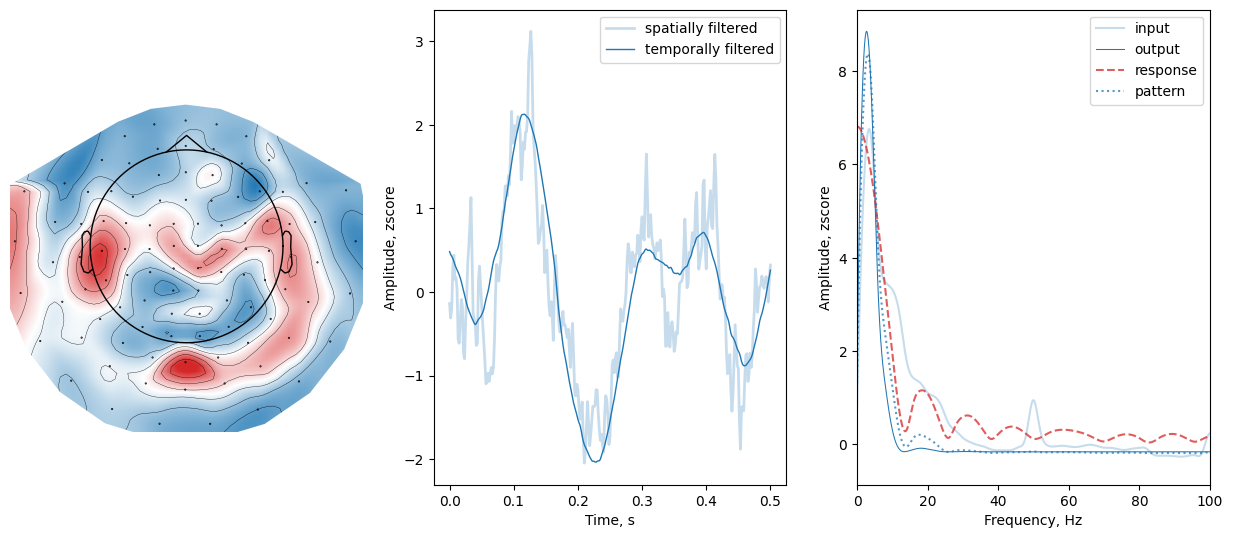

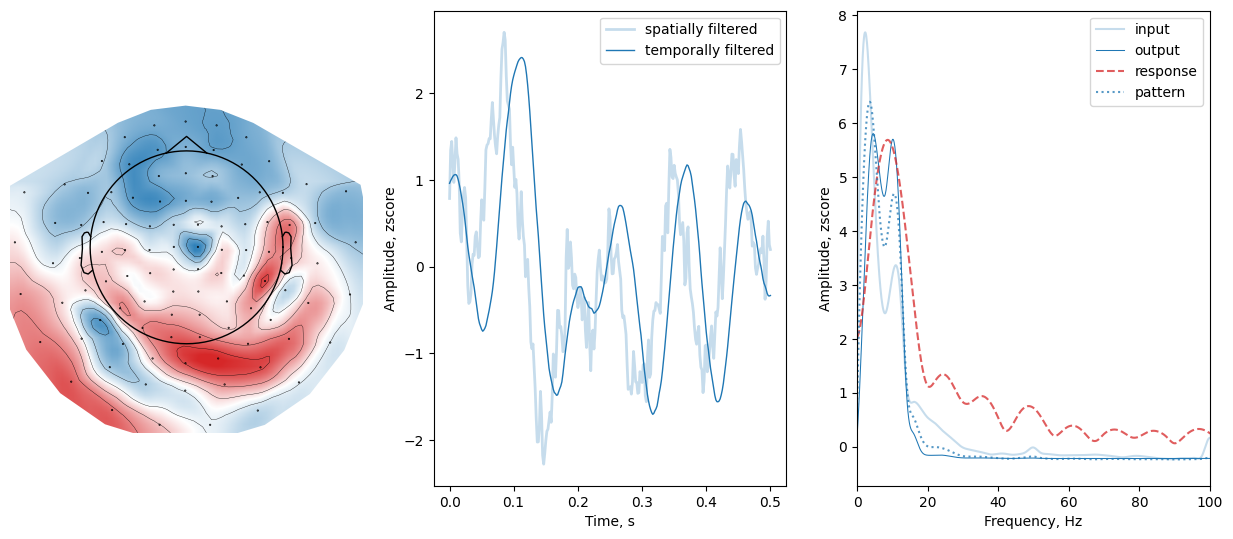

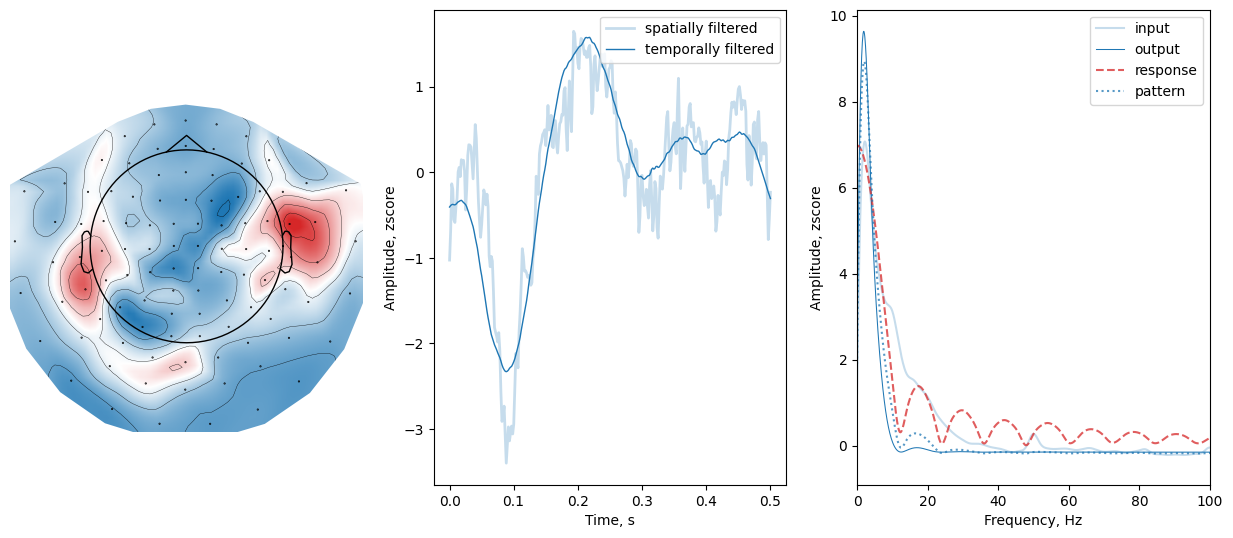

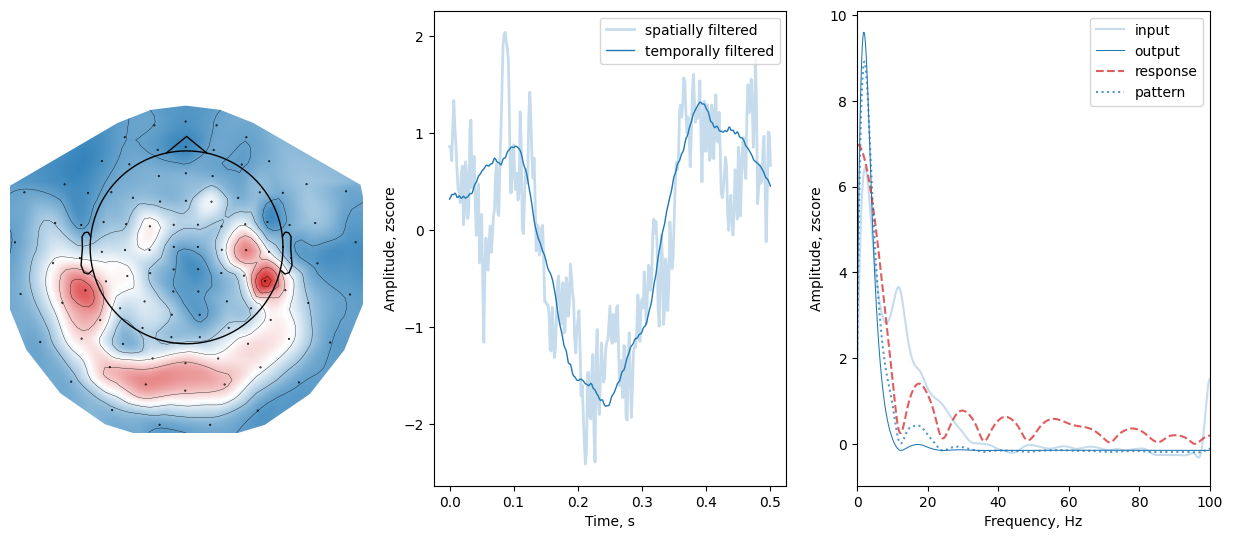

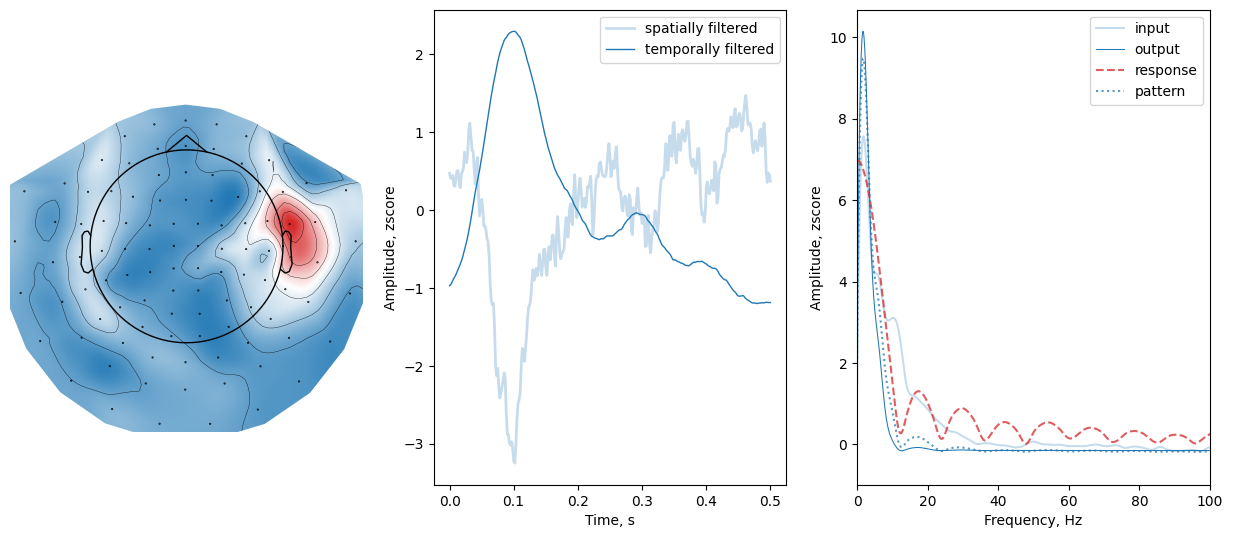

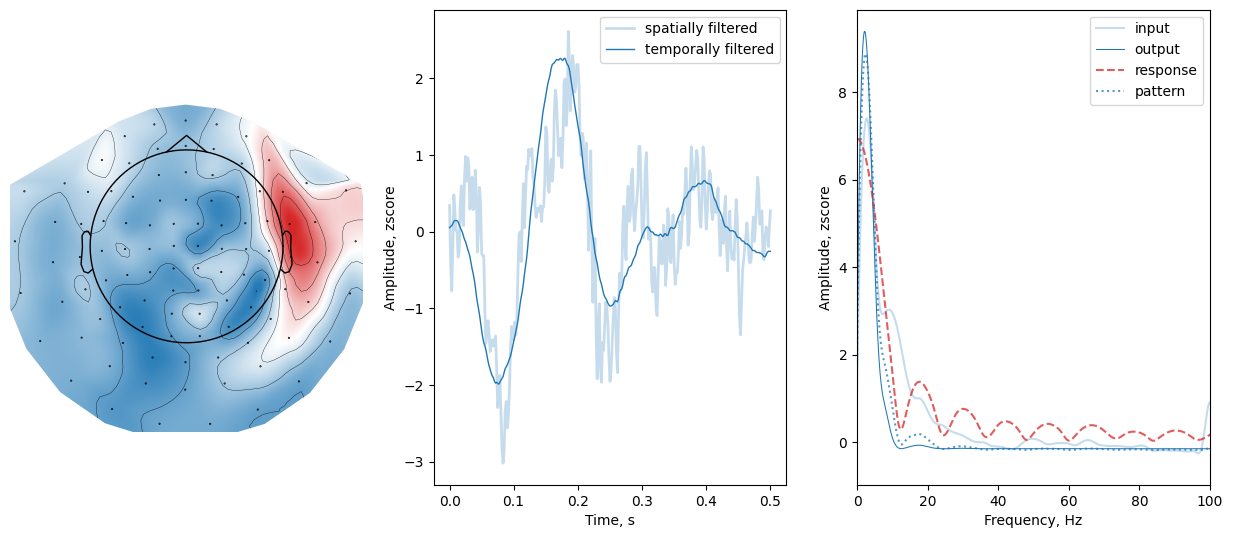

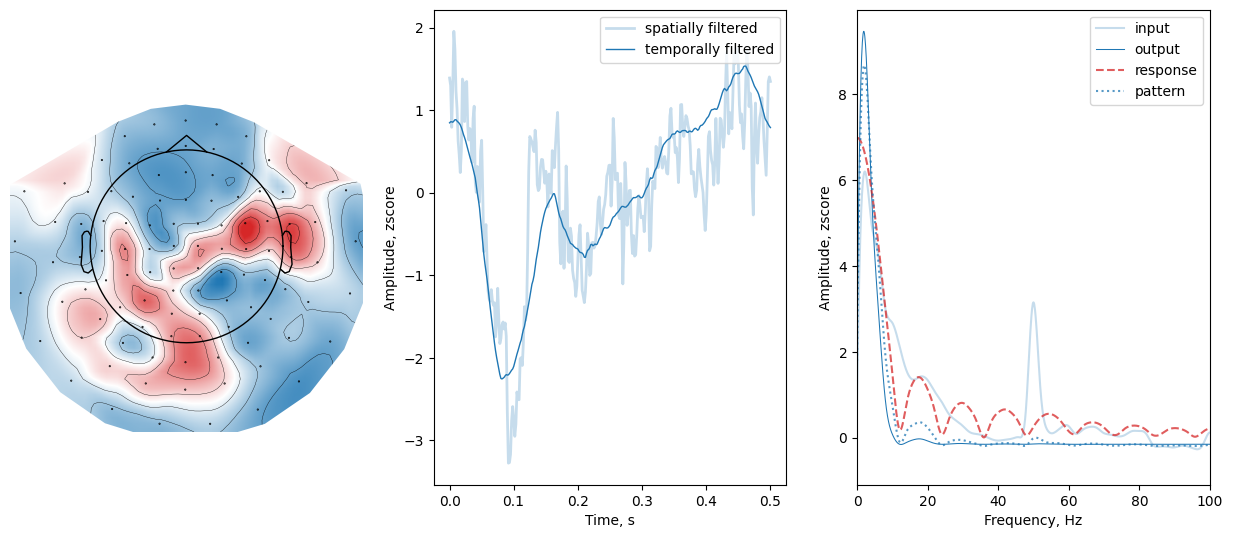

In [142]:
for i in range(8):
    fig = interpreter2.plot_branch(i, ['input', 'output', 'response', 'pattern'])
    plt.show()

In [31]:
interpreter.branchwise_loss

array([-0.08944099, -0.09267054, -0.0914609 , -0.03917013, -0.02047284,
       -0.15492104, -0.09462695, -0.08219619])

In [32]:
interpreter2.branchwise_loss

array([-0.0177549 , -0.08003019, -0.03629048, -0.052931  , -0.01471297,
       -0.01458216, -0.01927258, -0.01557697])

In [108]:
interpreter2.branchwise_loss

array([-0.03247683, -0.07247421, -0.06673473, -0.06026603, -0.04115203,
       -0.04275879, -0.08429301, -0.03346384])